In [ ]:
# Install the scikit-fuzzy library for fuzzy logic implementation
!pip install scikit-fuzzy

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # For advanced visualizations

# Import scikit-fuzzy for fuzzy logic-based computations
import skfuzzy as fuzz

# Import necessary machine learning tools from scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, classification_report
from sklearn.neural_network import MLPClassifier  # Multi-layer Perceptron (MLP) for deep learning
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# Ignore warnings to keep output clean
import warnings
warnings.filterwarnings('ignore')


# Step 1: Load Data and EDA


In [ ]:
df = pd.read_csv('migraine_data.csv') #laoding the dataset

In [ ]:
print("Data Head:") #Viewing first few row of the dataset
print(df.head())

Data Head:
   Age  Duration  Frequency  Location  Character  Intensity  Nausea  Vomit  \
0   30         1          5         1          1          2       1      0   
1   50         3          5         1          1          3       1      1   
2   53         2          1         1          1          2       1      1   
3   45         3          5         1          1          3       1      0   
4   53         1          1         1          1          2       1      0   

   Phonophobia  Photophobia  ...  Vertigo  Tinnitus  Hypoacusis  Diplopia  \
0            1            1  ...        0         0           0         0   
1            1            1  ...        1         0           0         0   
2            1            1  ...        0         0           0         0   
3            1            1  ...        1         0           0         0   
4            1            1  ...        0         0           0         0   

   Defect  Ataxia  Conscience  Paresthesia  DPF          

In [ ]:
print("\nData Description:")
# Display summary statistics of numerical columns in the DataFrame
print(df.describe())


Data Description:
              Age    Duration   Frequency    Location   Character  Intensity  \
count  400.000000  400.000000  400.000000  400.000000  400.000000  400.00000   
mean    31.705000    1.610000    2.365000    0.972500    0.977500    2.47000   
std     12.139043    0.770964    1.675947    0.268186    0.277825    0.76849   
min     15.000000    1.000000    1.000000    0.000000    0.000000    0.00000   
25%     22.000000    1.000000    1.000000    1.000000    1.000000    2.00000   
50%     28.000000    1.000000    2.000000    1.000000    1.000000    3.00000   
75%     40.000000    2.000000    4.000000    1.000000    1.000000    3.00000   
max     77.000000    3.000000    8.000000    2.000000    2.000000    3.00000   

           Nausea       Vomit  Phonophobia  Photophobia  ...  Dysarthria  \
count  400.000000  400.000000   400.000000   400.000000  ...    400.0000   
mean     0.987500    0.322500     0.977500     0.980000  ...      0.0025   
std      0.111242    0.468019   

In [ ]:
df.drop('Ataxia', axis=1, inplace=True) #Dpropping the column named Ataxia

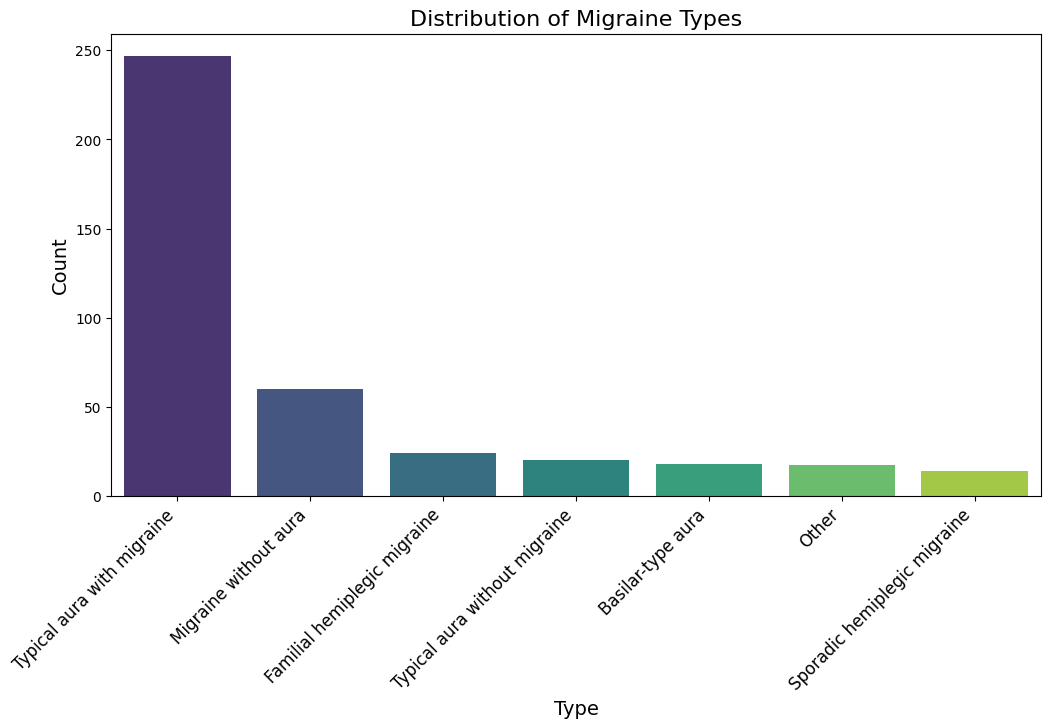

In [ ]:
type_counts = df['Type'].value_counts()
# Visualization of the distribution of migraine types in the dataset using a bar plot,
# improving readability with customized labels, rotation, and a color palette.
plt.figure(figsize=(12, 6))
sns.barplot(x=type_counts.index, y=type_counts.values, palette="viridis")
plt.xlabel("Type", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Distribution of Migraine Types", fontsize=16)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.show()

In [ ]:
#Using labelencoder for encoding
le = LabelEncoder()
df['Type_encoded'] = le.fit_transform(df['Type'])
target = df['Type_encoded']

In [ ]:
# Find the minimum, maximum and mean value in the target variable
t_min = target.min()
t_max = target.max()
t_mid = target.mean()

# Calculate the left threshold: halfway between the minimum value and the mean
L = t_min + (t_mid - t_min) / 2

# Calculate the right threshold: halfway between the maximum value and the mean
R = t_max - (t_max - t_mid) / 2

# Create an array named universe of 100 evenly spaced values between t_min and t_max
universe = np.linspace(t_min, t_max, 100)


In [ ]:
# Left Shoulder Membership Function (for Low)
# This function defines a trapezoidal membership function where:
# - 'a' and 'b' determine the flat lower boundary (left shoulder).
# - 'c' determines the decreasing slope.
def left_shoulder(universe, a, b, c):
    return fuzz.trapmf(universe, [a, a, b, c])

# Right Shoulder Membership Function (for High)
# This function defines a trapezoidal membership function where:
# - 'a' determines the increasing slope.
# - 'b' and 'c' define the flat upper boundary (right shoulder).
def right_shoulder(universe, a, b, c):
    return fuzz.trapmf(universe, [a, b, c, c])

# Triangular Membership Function (for Medium)
# This function defines a triangular membership function where:
# - 'a' is the left base of the triangle.
# - 'b' is the peak (highest membership value).
# - 'c' is the right base of the triangle.
def triangular(universe, a, b, c):
    return fuzz.trimf(universe, [a, b, c])


In [ ]:
mu_low = left_shoulder(universe, t_min, L, t_mid)  # Fuzzy membership values for the "Low" category
mu_med = triangular(universe, L, t_mid, R)  # Fuzzy membership values for the "Medium" category
mu_high = right_shoulder(universe, t_mid, R, t_max)  # Fuzzy membership values for the "High" category

In [ ]:
# Creating a function to compute fuzzy membership values for a given input value
def compute_memberships(value):
    m_low  = fuzz.interp_membership(universe, mu_low, value)  # Compute membership in the "Low" fuzzy set
    m_med  = fuzz.interp_membership(universe, mu_med, value)  # Compute membership in the "Medium" fuzzy set
    m_high = fuzz.interp_membership(universe, mu_high, value)  # Compute membership in the "High" fuzzy set
    return m_low, m_med, m_high  # Return membership values for all fuzzy sets

In [ ]:
# Apply the compute_memberships function to each value in the target column
memberships = target.apply(compute_memberships)

# Convert the list of membership values into a NumPy array for easier indexing
memberships = np.array(list(memberships))

# Assign the computed "Low" membership values to a new column in the DataFrame
df['mu_low'] = memberships[:, 0]

# Assign the computed "Medium" membership values to a new column in the DataFrame
df['mu_med'] = memberships[:, 1]

# Assign the computed "High" membership values to a new column in the DataFrame
df['mu_high'] = memberships[:, 2]

# Determine the fuzzy label by finding the index of the highest membership value (0 = Low, 1 = Medium, 2 = High)
df['fuzzy_label'] = df.apply(lambda row: np.argmax([row['mu_low'], row['mu_med'], row['mu_high']]), axis=1)

# Print a sample of the fuzzified target values, showing original type and computed fuzzy values
print("\nSample of fuzzified target (Migraine Type):")
print(df[['Type', 'Type_encoded', 'mu_low', 'mu_med', 'mu_high', 'fuzzy_label']].head())



Sample of fuzzified target (Migraine Type):
                         Type  Type_encoded  mu_low    mu_med   mu_high  \
0  Typical aura with migraine             5     0.0  0.019044  0.980956   
1  Typical aura with migraine             5     0.0  0.019044  0.980956   
2  Typical aura with migraine             5     0.0  0.019044  0.980956   
3  Typical aura with migraine             5     0.0  0.019044  0.980956   
4  Typical aura with migraine             5     0.0  0.019044  0.980956   

   fuzzy_label  
0            2  
1            2  
2            2  
3            2  
4            2  


# Step 3: Prepare Data for Modeling


In [ ]:
# Define columns to drop as they are not needed for model training
drop_cols = ['Type', 'Type_encoded', 'mu_low', 'mu_med', 'mu_high', 'fuzzy_label']

# Select only numerical columns from the DataFrame and drop the specified columns if they exist
X = df.select_dtypes(include=[np.number]).drop(columns=drop_cols, errors='ignore')

# Define the target variable for fuzzy classification (fuzzy labels)
y_fuzzy = df['fuzzy_label']

# Define the target variable for crisp classification (original encoded labels)
y_crisp = df['Type_encoded']

# Split the dataset into training and testing sets (80% train, 20% test)
# X: Features, y_fuzzy: Fuzzy target labels, y_crisp: Original encoded labels
X_train, X_test, y_train, y_test, y_train_crisp, y_test_crisp = train_test_split(
    X, y_fuzzy, y_crisp, test_size=0.2, random_state=42)  # Set random_state for reproducibility


# Step 4: Fuzzy Classification & Model Training


In [ ]:
# Define a dictionary of classification models for fuzzy label prediction
fuzzy_models = {
    "Neural Network": MLPClassifier(hidden_layer_sizes=(10, 10), max_iter=500, random_state=42),  # Multi-layer Perceptron with two hidden layers
    "SVM": SVC(probability=True, random_state=42),  # Support Vector Machine with probability estimation
    "KNN": KNeighborsClassifier(n_neighbors=5),  # K-Nearest Neighbors with k=5
    "Decision Tree": DecisionTreeClassifier(random_state=42),  # Decision Tree classifier
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)  # Random Forest with 100 estimators
}

# Initialize an empty dictionary to store model accuracies
fuzzy_results = {}

# Print header for classification accuracy results
print("\n--- Fuzzy Label Classification Accuracies ---")

# Train and evaluate each model on the fuzzy labels
for name, model in fuzzy_models.items():
    model.fit(X_train, y_train)  # Train the model
    preds = model.predict(X_test)  # Make predictions on the test set
    acc = accuracy_score(y_test, preds)  # Calculate accuracy
    fuzzy_results[name] = acc  # Store accuracy in the results dictionary
    print(f"{name}: {acc * 100:.2f}%")  # Print accuracy percentage

# Identify the best-performing model based on accuracy
best_fuzzy_model_name = max(fuzzy_results, key=fuzzy_results.get)
best_fuzzy_model = fuzzy_models[best_fuzzy_model_name]  # Retrieve the best model


--- Fuzzy Label Classification Accuracies ---
Neural Network: 96.25%
SVM: 65.00%
KNN: 77.50%
Decision Tree: 95.00%
Random Forest: 93.75%


In [ ]:
# Print the best-performing fuzzy classification model
print(f"\nBest fuzzy model based on classification: {best_fuzzy_model_name}")

# Indicate that the selected best model will be used for defuzzification
print(f"Using {best_fuzzy_model_name} for defuzzification.")


Best fuzzy model based on classification: Neural Network
Using Neural Network for defuzzification.


# Step 5: Fuzzy Defuzzification Using the Best Model


In [ ]:
# Compute the centroid (defuzzified crisp value) for the "Low" fuzzy set
centroid_low  = fuzz.defuzz(universe, mu_low, 'centroid')

# Compute the centroid (defuzzified crisp value) for the "Medium" fuzzy set
centroid_med  = fuzz.defuzz(universe, mu_med, 'centroid')

# Compute the centroid (defuzzified crisp value) for the "High" fuzzy set
centroid_high = fuzz.defuzz(universe, mu_high, 'centroid')

# Print the representative crisp values for each fuzzy category
print("\nRepresentative crisp values (centroids):")
print(f"Low: {centroid_low:.2f}, Medium: {centroid_med:.2f}, High: {centroid_high:.2f}")


Representative crisp values (centroids):
Low: 1.56, Medium: 3.68, High: 5.23


In [ ]:
# Get predicted probabilities for each class using the best fuzzy classification model
y_prob = best_fuzzy_model.predict_proba(X_test)

# Define a function to perform centroid-based defuzzification
def defuzzify_centroid(probs):
    return (probs[0] * centroid_low + probs[1] * centroid_med + probs[2] * centroid_high) / np.sum(probs)

# Define a function to perform max-membership (MOM) defuzzification
def defuzzify_mom(probs):
    idx = np.argmax(probs)  # Get the index of the highest probability
    return [centroid_low, centroid_med, centroid_high][idx]  # Return corresponding centroid value

# Apply centroid-based defuzzification to all probability outputs
defuzz_centroid = np.array([defuzzify_centroid(probs) for probs in y_prob])

# Apply max-membership (MOM) defuzzification to all probability outputs
defuzz_mom = np.array([defuzzify_mom(probs) for probs in y_prob])

# Compute the Root Mean Squared Error (RMSE) between crisp labels and centroid defuzzification
rmse_centroid = np.sqrt(mean_squared_error(y_test_crisp, defuzz_centroid))

# Compute the RMSE between crisp labels and MOM defuzzification
rmse_mom = np.sqrt(mean_squared_error(y_test_crisp, defuzz_mom))

In [ ]:
# Print the RMSE comparison results for defuzzification methods
print("\n--- Fuzzy Defuzzification RMSE Comparison ---")

# Print the RMSE for the Centroid defuzzification method
print(f"Centroid Method RMSE: {rmse_centroid:.4f}")

# Print the RMSE for the Mean of Maxima (MOM) defuzzification method
print(f"Mean of Maxima (MOM) RMSE: {rmse_mom:.4f}")

# Determine which defuzzification method is more accurate based on RMSE
if rmse_centroid < rmse_mom:
    print("The Centroid defuzzification method is more accurate based on RMSE.")
else:
    print("The Mean of Maxima (MOM) defuzzification method is more accurate based on RMSE.")


--- Fuzzy Defuzzification RMSE Comparison ---
Centroid Method RMSE: 0.8323
Mean of Maxima (MOM) RMSE: 0.8355
The Centroid defuzzification method is more accurate based on RMSE.


# Step 6: Non-Fuzzy Prediction (Direct Classification on Type_encoded)


In [ ]:
# Define the non-fuzzy target variable (original encoded labels)
non_fuzzy_target = df['Type_encoded']

# Split the dataset into training and testing sets for non-fuzzy classification (80% train, 20% test)
X_train_nf, X_test_nf, y_train_nf, y_test_nf = train_test_split(
    X, non_fuzzy_target, test_size=0.2, random_state=42)  # Set random_state for reproducibility

# Define a dictionary of classification models for non-fuzzy (crisp) label prediction
non_fuzzy_models = {
    "Neural Network": MLPClassifier(hidden_layer_sizes=(10, 10), max_iter=500, random_state=42),  # Multi-layer Perceptron
    "SVM": SVC(probability=True, random_state=42),  # Support Vector Machine
    "KNN": KNeighborsClassifier(n_neighbors=5),  # K-Nearest Neighbors
    "Decision Tree": DecisionTreeClassifier(random_state=42),  # Decision Tree classifier
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)  # Random Forest with 100 estimators
}

In [ ]:
# Dictionary to store accuracy results for non-fuzzy classification
non_fuzzy_results = {}

# Print header for non-fuzzy classification accuracy results
print("\n--- Non-Fuzzy Classification Accuracies ---")

# Train and evaluate each non-fuzzy classification model
for name, model in non_fuzzy_models.items():
    model.fit(X_train_nf, y_train_nf)  # Train the model on the non-fuzzy training data
    preds_nf = model.predict(X_test_nf)  # Predict on the test set
    acc_nf = accuracy_score(y_test_nf, preds_nf)  # Calculate accuracy
    non_fuzzy_results[name] = acc_nf  # Store accuracy in results dictionary
    print(f"{name}: {acc_nf * 100:.2f}%")  # Print accuracy for each model

# Identify the best non-fuzzy model based on highest accuracy
best_non_fuzzy_model_name = max(non_fuzzy_results, key=non_fuzzy_results.get)
best_non_fuzzy_model = non_fuzzy_models[best_non_fuzzy_model_name]

# Print the best-performing non-fuzzy classification model
print(f"\nBest non-fuzzy model based on classification: {best_non_fuzzy_model_name}")


--- Non-Fuzzy Classification Accuracies ---
Neural Network: 88.75%
SVM: 61.25%
KNN: 75.00%
Decision Tree: 86.25%
Random Forest: 95.00%

Best non-fuzzy model based on classification: Random Forest


# Step 7: Print Classification Reports (text output)


In [ ]:
# Step 7: Print Classification Reports & Confusion Matrix
print("\n--- Fuzzy Model Classification Reports ---")
# Neural Network Fuzzy
print(f"\nFuzzy Classification Report - Neural Network")
preds = fuzzy_models['Neural Network'].predict(X_test)
print(classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))

# SVM Fuzzy
print(f"\nFuzzy Classification Report - SVM")
preds = fuzzy_models['SVM'].predict(X_test)
print(classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))

# KNN Fuzzy
print(f"\nFuzzy Classification Report - KNN")
preds = fuzzy_models['KNN'].predict(X_test)
print(classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))

# Decision Tree Fuzzy
print(f"\nFuzzy Classification Report - Decision Tree")
preds = fuzzy_models['Decision Tree'].predict(X_test)
print(classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))

# Random Forest Fuzzy
print(f"\nFuzzy Classification Report - Random Forest")
preds = fuzzy_models['Random Forest'].predict(X_test)
print(classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))

print("\n--- Non-Fuzzy Model Classification Reports ---")
# Neural Network Non-Fuzzy
print(f"\nNon-Fuzzy Classification Report - Neural Network")
preds_nf = non_fuzzy_models['Neural Network'].predict(X_test_nf)
print(classification_report(y_test_nf, preds_nf))
print(confusion_matrix(y_test_nf, preds_nf))

# SVM Non-Fuzzy
print(f"\nNon-Fuzzy Classification Report - SVM")
preds_nf = non_fuzzy_models['SVM'].predict(X_test_nf)
print(classification_report(y_test_nf, preds_nf))
print(confusion_matrix(y_test_nf, preds_nf))

# KNN Non-Fuzzy
print(f"\nNon-Fuzzy Classification Report - KNN")
preds_nf = non_fuzzy_models['KNN'].predict(X_test_nf)
print(classification_report(y_test_nf, preds_nf))
print(confusion_matrix(y_test_nf, preds_nf))

# Decision Tree Non-Fuzzy
print(f"\nNon-Fuzzy Classification Report - Decision Tree")
preds_nf = non_fuzzy_models['Decision Tree'].predict(X_test_nf)
print(classification_report(y_test_nf, preds_nf))
print(confusion_matrix(y_test_nf, preds_nf))

# Random Forest Non-Fuzzy
print(f"\nNon-Fuzzy Classification Report - Random Forest")
preds_nf = non_fuzzy_models['Random Forest'].predict(X_test_nf)
print(classification_report(y_test_nf, preds_nf))
print(confusion_matrix(y_test_nf, preds_nf))



--- Fuzzy Model Classification Reports ---

Fuzzy Classification Report - Neural Network
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        26
           1       1.00      0.50      0.67         2
           2       0.98      0.96      0.97        52

    accuracy                           0.96        80
   macro avg       0.97      0.82      0.87        80
weighted avg       0.96      0.96      0.96        80

[[26  0  0]
 [ 0  1  1]
 [ 2  0 50]]

Fuzzy Classification Report - SVM
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.00      0.00      0.00         2
           2       0.65      1.00      0.79        52

    accuracy                           0.65        80
   macro avg       0.22      0.33      0.26        80
weighted avg       0.42      0.65      0.51        80

[[ 0  0 26]
 [ 0  0  2]
 [ 0  0 52]]

Fuzzy Classification Report - KNN
    

In [ ]:
# Print classification reports for fuzzy and non-fuzzy models

print("\n--- Fuzzy Model Classification Reports ---")
for name, model in fuzzy_models.items():
    print(f"\nFuzzy Classification Report - {name}")
    preds = model.predict(X_test)  # Predict on fuzzy test set
    print(classification_report(y_test, preds))  # Print classification report

print("\n--- Non-Fuzzy Model Classification Reports ---")
for name, model in non_fuzzy_models.items():
    print(f"\nNon-Fuzzy Classification Report - {name}")
    preds_nf = model.predict(X_test_nf)  # Predict on non-fuzzy test set
    print(classification_report(y_test_nf, preds_nf))  # Print classification report


--- Fuzzy Model Classification Reports ---

Fuzzy Classification Report - Neural Network
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        26
           1       1.00      0.50      0.67         2
           2       0.98      0.96      0.97        52

    accuracy                           0.96        80
   macro avg       0.97      0.82      0.87        80
weighted avg       0.96      0.96      0.96        80


Fuzzy Classification Report - SVM
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.00      0.00      0.00         2
           2       0.65      1.00      0.79        52

    accuracy                           0.65        80
   macro avg       0.22      0.33      0.26        80
weighted avg       0.42      0.65      0.51        80


Fuzzy Classification Report - KNN
              precision    recall  f1-score   support

           0       0.86

# Step 8: Summary of Results


In [ ]:
# Print summary of results

print("\nSummary of Results:")

# Print accuracy of fuzzy models
print("Fuzzy Models (using fuzzified 'Type'):")
for name, acc in fuzzy_results.items():
    print(f"  {name}: {acc * 100:.2f}% accuracy")

# Print accuracy of non-fuzzy models
print("\nNon-Fuzzy Models (direct prediction on Type_encoded):")
for name, acc in non_fuzzy_results.items():
    print(f"  {name}: {acc * 100:.2f}% accuracy")

# Print RMSE values for defuzzification methods
print("\nDefuzzification (using best fuzzy model):")
print(f"  Centroid Method RMSE: {rmse_centroid:.4f}")
print(f"  Mean of Maxima (MOM) RMSE: {rmse_mom:.4f}")


Summary of Results:
Fuzzy Models (using fuzzified 'Type'):
  Neural Network: 96.25% accuracy
  SVM: 65.00% accuracy
  KNN: 77.50% accuracy
  Decision Tree: 95.00% accuracy
  Random Forest: 93.75% accuracy

Non-Fuzzy Models (direct prediction on Type_encoded):
  Neural Network: 88.75% accuracy
  SVM: 61.25% accuracy
  KNN: 75.00% accuracy
  Decision Tree: 86.25% accuracy
  Random Forest: 95.00% accuracy

Defuzzification (using best fuzzy model):
  Centroid Method RMSE: 0.8323
  Mean of Maxima (MOM) RMSE: 0.8355


# Step 9: Bar Chart Comparison of Fuzzy vs Non-Fuzzy Model Accuracies


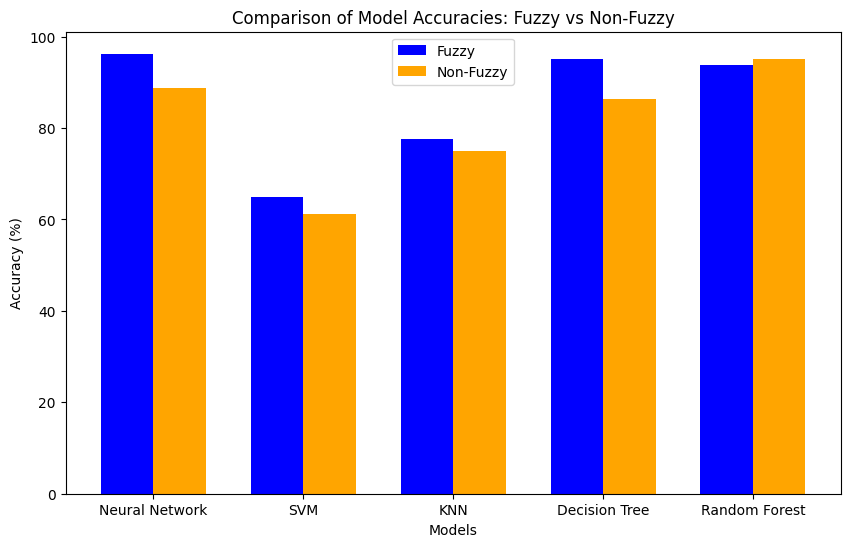

In [ ]:
# Create a list of model names
models_list = list(fuzzy_results.keys())

# Extract accuracy values for fuzzy and non-fuzzy models
fuzzy_acc = [fuzzy_results[m] * 100 for m in models_list]
non_fuzzy_acc = [non_fuzzy_results[m] * 100 for m in models_list]

# Define x-axis positions
x = np.arange(len(models_list))
width = 0.35  # Width of the bars

# Plot bar chart comparing fuzzy and non-fuzzy model accuracies
plt.figure(figsize=(10,6))
plt.bar(x - width/2, fuzzy_acc, width, label='Fuzzy', color='blue')
plt.bar(x + width/2, non_fuzzy_acc, width, label='Non-Fuzzy', color='orange')

# Set axis labels and title
plt.xticks(x, models_list)
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Comparison of Model Accuracies: Fuzzy vs Non-Fuzzy')
plt.legend()
plt.show()